# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import time
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   return("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Удалим неинформативные столбцы DateCrawled, DateCreated, PostalCode, LastSeen:

In [6]:
df = df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen'], axis=1)

Обработаем пропуски:

In [7]:
df.isna().sum()/len(df)*100

Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
NumberOfPictures      0.000000
dtype: float64

Пропусков довольно много, от 5.6% до 20%. Отметим, что все это столбцы с типом данных object, поэтому не получится заполнить пропуски соседними значениями.

 Заменим значения NaN на unknown:

In [8]:
df['VehicleType'] = df['VehicleType'].fillna(value='unknown');

In [9]:
df['Gearbox'] = df['Gearbox'].fillna(value='unknown');

In [10]:
df['Model'] = df['Model'].fillna(value='unknown');

In [11]:
df['FuelType'] = df['FuelType'].fillna(value='unknown');

In [12]:
df['Repaired'] = df['Repaired'].fillna(value='unknown');

In [13]:
#check
df.isna().sum()/len(df)*100

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
NumberOfPictures     0.0
dtype: float64

**Посмотрим на заполненность данных в числовых значениях:**

In [14]:
for i in df.columns:
    print(i, df.loc[df[i] == 0 , i].count()/len(df)*100)

Price 3.0397692800442475
VehicleType 0.0
RegistrationYear 0.0
Gearbox 0.0
Power 11.351162206626427
Model 0.0
Kilometer 0.0
RegistrationMonth 10.540425375808832
FuelType 0.0
Brand 0.0
Repaired 0.0
NumberOfPictures 100.0


Достаточно много позиций заполнены нулями. Характер данных не позволяет заполнить их соседними значениями, оставим их как есть, только удалим столбец NumberOfPictures - он заполнен нулями на 100%. 

In [15]:
df = df.drop(['NumberOfPictures'], axis=1)

In [16]:
#check
len(df)

354369

In [17]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Видим подозрительные значения в RegistrationYear, Power, Kilometer. Рассмотрим их далее

**RegistrationYear**

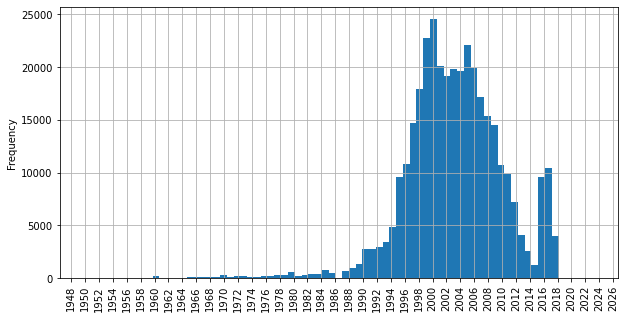

In [18]:
df['RegistrationYear'].plot(kind='hist', bins=75, figsize=(10,5), rot=90, grid=True, range=(1950, 2023));
plt.locator_params(axis='x', nbins = 60)

In [19]:
#check
df.loc[(df['RegistrationYear']<1950) | (df['RegistrationYear']>2023), 'RegistrationYear'].count()/len(df)*100

0.09904929607273774

Около 0.1 процента составляют значения менее 1950 либо больше 2023, удалим такие строки

In [20]:
df = df[(df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] <= 2023)]

In [21]:
#check
df.loc[(df['RegistrationYear']<1950) | (df['RegistrationYear']>2023), 'RegistrationYear'].count()

0

**Power**

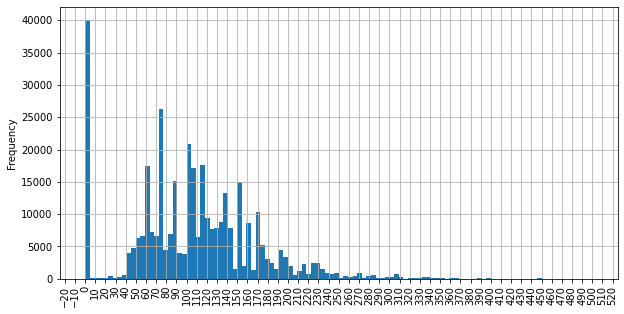

In [22]:
df['Power'].plot(kind='hist', bins=110, figsize=(10,5), rot=90, grid=True, range=(0, 500));
plt.locator_params(axis='x', nbins = 60)

In [23]:
df.loc[((df['Power']<30) | (df['Power']>600)) & (df['Power'] != 0), 'RegistrationYear'].count()/len(df)*100

0.35478422001141185

Как мы узнали ранее, около 11% данных Power заполнены нулями. Оставим их.

Тем не менее, около 0.35% данных имеют аномальные значения менее 30 либо более 600. Удалим их

In [24]:
df = df[((df['Power'] >= 30) & (df['Power'] <= 600)) | (df['Power'] == 0)]

In [25]:
#check
df.loc[((df['Power']<30) | (df['Power']>600)) & (df['Power'] != 0), 'RegistrationYear'].count()/len(df)*100

0.0

**Kilometer**

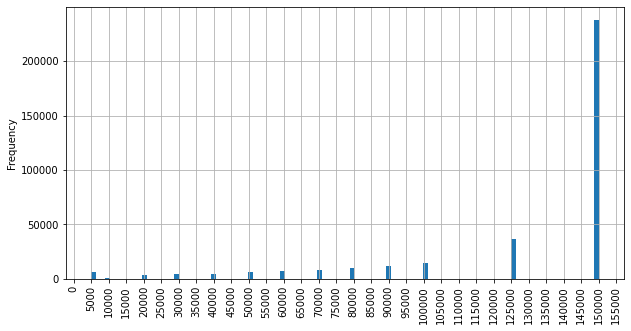

In [26]:
df['Kilometer'].plot(kind='hist', bins=110, figsize=(10,5), rot=90, grid=True);
plt.locator_params(axis='x', nbins = 60)

In [27]:
#check
df['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000, 100000,  60000,
         5000,  20000,  80000,  50000,  10000], dtype=int64)

In [28]:
df['Kilometer'].value_counts()/len(df)*100

150000    67.409755
125000    10.313753
100000     4.199432
90000      3.263957
80000      2.833072
70000      2.415226
60000      2.087243
50000      1.743952
5000       1.720140
40000      1.369195
30000      1.230858
20000      1.098191
10000      0.315227
Name: Kilometer, dtype: float64

порядка 67% всех значений это 150тыс км, видимо, это максимально большое значение, доступное к выбору. Скорее всего, имелось в виду "150тыс и более". Оставим, как есть.

In [29]:
#check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352762 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              352762 non-null  int64 
 1   VehicleType        352762 non-null  object
 2   RegistrationYear   352762 non-null  int64 
 3   Gearbox            352762 non-null  object
 4   Power              352762 non-null  int64 
 5   Model              352762 non-null  object
 6   Kilometer          352762 non-null  int64 
 7   RegistrationMonth  352762 non-null  int64 
 8   FuelType           352762 non-null  object
 9   Brand              352762 non-null  object
 10  Repaired           352762 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.3+ MB


In [30]:
#check
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,352762.000000,352762.000000,352762.000000,352762.000000,352762.000000
mean,4421.310351,2003.160510,106.777589,128479.357187,5.720707
std,4515.877666,7.238426,63.330216,37584.921102,3.724276
min,0.000000,1950.000000,0.000000,5000.000000,0.000000
25%,1090.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,2019.000000,600.000000,150000.000000,12.000000


**Вывод:** Данные подготовлены, потери составили 0.45%, что допустимо.

## Обучение моделей

Разделим данные на выборки и выделим целевой признак

Разделим данные на выборки в пропорции 60:20:20

In [31]:
features = df.drop(['Price'], axis = 1)  
target = df['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.2,train_size=0.8,random_state=123)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25,train_size=0.75,random_state=123)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(211656, 10)
(70553, 10)
(70553, 10)


In [32]:
#check
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Обучение моделей и подбор гиперпараметров
LGBMRegressor
Судя по документации LGBMRegressor не требует кодирования категориальных признаков
categorical_feature — принимает список строк/целых чисел или строку auto. Если мы передадим список строк/целых чисел, тогда указанные столбцы из набора данных будут рассматриваться как категориальные.

In [33]:
display(features_train.head(1))
categorical_features = [0,2,4,7,8,9]
print(categorical_features)
for i in ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']:
    features_train[i]=features_train[i].astype('category')
    features_valid[i]=features_valid[i].astype('category')
    features_test[i]=features_test[i].astype('category')

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
117935,unknown,2017,auto,0,a3,150000,0,petrol,audi,unknown


[0, 2, 4, 7, 8, 9]


In [34]:
%%time

start = time.time() 

LGBM_model = lgb.LGBMRegressor(num_leaves= 100, learning_rate=0.05, max_depth=15, n_estimators=100)
LGBM_model.fit(features_train, target_train, eval_metric='rmse', categorical_feature=categorical_features)

end = time.time()

LGBM_learn=exec_time(start,end)

print(LGBM_learn)

Time: 00:00:01
00:00:01
Wall time: 1.07 s


In [35]:
%%time

start = time.time() 

predicted_test_LGBM = LGBM_model.predict(features_test)

end = time.time()

print('RMSE for LGBMR -> test:', mean_squared_error(target_test, predicted_test_LGBM) ** 0.5)

LGBM_predict=exec_time(start,end)
LGBM_RMSE=mean_squared_error(target_test, predicted_test_LGBM) ** 0.5
print(LGBM_predict)

RMSE for LGBMR -> test: 1725.6953195767103
Time: 00:00:00
00:00:00
Wall time: 169 ms


In [46]:
%%time
param_grid = {'max_depth':[5,15],
              'learning_rate': [0.05,0.1],
              }
LGBM_model = lgb.LGBMRegressor()
                                  
parameters_LGBM = GridSearchCV(estimator = LGBM_model,param_grid = param_grid,n_jobs=1,verbose=10,scoring= 'neg_root_mean_squared_error',cv=5)

parameters_LGBM.fit(features_train, target_train)
print('best params\n', parameters_LGBM.best_params_)
print('best RMSE\n', -parameters_LGBM.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START learning_rate=0.05, max_depth=5.............................
[CV 1/5; 1/4] END ...........learning_rate=0.05, max_depth=5; total time=   0.5s
[CV 2/5; 1/4] START learning_rate=0.05, max_depth=5.............................
[CV 2/5; 1/4] END ...........learning_rate=0.05, max_depth=5; total time=   0.5s
[CV 3/5; 1/4] START learning_rate=0.05, max_depth=5.............................
[CV 3/5; 1/4] END ...........learning_rate=0.05, max_depth=5; total time=   0.5s
[CV 4/5; 1/4] START learning_rate=0.05, max_depth=5.............................
[CV 4/5; 1/4] END ...........learning_rate=0.05, max_depth=5; total time=   0.5s
[CV 5/5; 1/4] START learning_rate=0.05, max_depth=5.............................
[CV 5/5; 1/4] END ...........learning_rate=0.05, max_depth=5; total time=   0.5s
[CV 1/5; 2/4] START learning_rate=0.05, max_depth=15............................
[CV 1/5; 2/4] END ..........learning_rate=0.05, m

**CatBoost**

CatBoost также не требует кодирования категориальных признаков

In [37]:
%%time

start = time.time() 

CatBoost_model = CatBoostRegressor(iterations = 150, l2_leaf_reg=10, max_depth=10,loss_function = 'RMSE',eval_metric = 'RMSE')
CatBoost_model.fit(features_train, target_train, cat_features=categorical_features,verbose=10)

end = time.time()
CatBoost_learn=exec_time(start,end)

0:	learn: 4422.4209527	total: 225ms	remaining: 33.6s
10:	learn: 3657.7957766	total: 1.07s	remaining: 13.5s
20:	learn: 3137.0653966	total: 1.88s	remaining: 11.5s
30:	learn: 2782.7250366	total: 2.69s	remaining: 10.3s
40:	learn: 2532.5515445	total: 3.5s	remaining: 9.31s
50:	learn: 2351.2492037	total: 4.32s	remaining: 8.39s
60:	learn: 2228.8048335	total: 5.14s	remaining: 7.5s
70:	learn: 2136.9858280	total: 5.94s	remaining: 6.61s
80:	learn: 2066.4648854	total: 6.76s	remaining: 5.75s
90:	learn: 2016.9131210	total: 7.57s	remaining: 4.91s
100:	learn: 1981.3538469	total: 8.38s	remaining: 4.07s
110:	learn: 1954.9871153	total: 9.18s	remaining: 3.23s
120:	learn: 1935.6929647	total: 9.99s	remaining: 2.39s
130:	learn: 1919.5800222	total: 10.8s	remaining: 1.56s
140:	learn: 1906.2364713	total: 11.6s	remaining: 740ms
149:	learn: 1896.5951806	total: 12.3s	remaining: 0us
Time: 00:00:13
Wall time: 12.6 s


In [38]:
%%time

start = time.time() 

predicted_test_CatBoost = CatBoost_model.predict(features_test)

end = time.time()

CatBoost_predict=exec_time(start,end)

print('RMSE for CatBoost -> test:', mean_squared_error(target_test, predicted_test_CatBoost) ** 0.5)

CatBoost_RMSE=mean_squared_error(target_test, predicted_test_CatBoost) ** 0.5

Time: 00:00:00
RMSE for CatBoost -> test: 1893.6199689314478
Wall time: 60.8 ms


In [39]:
%%time
param_grid = {'l2_leaf_reg':[10,15],
              'max_depth': [10,15],
              }
CatBoost_model = CatBoostRegressor(loss_function="RMSE", iterations=50,cat_features=categorical_features)
                                  
parameters_CatBoost = GridSearchCV(estimator = CatBoost_model,param_grid = param_grid,n_jobs=1,scoring= 'neg_root_mean_squared_error',cv=5)

parameters_CatBoost.fit(features_train, target_train)
print('best params\n', parameters_CatBoost.best_params_)
print('best RMSE\n', -parameters_CatBoost.best_score_)

0:	learn: 4420.7143043	total: 83.8ms	remaining: 4.11s
1:	learn: 4331.4253109	total: 158ms	remaining: 3.78s
2:	learn: 4244.5088044	total: 233ms	remaining: 3.64s
3:	learn: 4160.6293526	total: 318ms	remaining: 3.66s
4:	learn: 4080.9684856	total: 392ms	remaining: 3.53s
5:	learn: 4003.1601934	total: 466ms	remaining: 3.42s
6:	learn: 3929.0668058	total: 546ms	remaining: 3.35s
7:	learn: 3856.7592777	total: 621ms	remaining: 3.26s
8:	learn: 3787.3241037	total: 698ms	remaining: 3.18s
9:	learn: 3720.6601358	total: 771ms	remaining: 3.08s
10:	learn: 3656.6251163	total: 858ms	remaining: 3.04s
11:	learn: 3594.8179811	total: 930ms	remaining: 2.94s
12:	learn: 3535.0603587	total: 1s	remaining: 2.85s
13:	learn: 3478.0280823	total: 1.08s	remaining: 2.78s
14:	learn: 3423.2046840	total: 1.16s	remaining: 2.7s
15:	learn: 3369.6409115	total: 1.23s	remaining: 2.61s
16:	learn: 3318.5380256	total: 1.3s	remaining: 2.53s
17:	learn: 3269.3448715	total: 1.38s	remaining: 2.45s
18:	learn: 3222.5875105	total: 1.46s	remai

**Случайный лес**

Для случайного леса придется кодировать категориальные признаки, используем OHE кодирование

Разделим кодированные данные на датасеты

Количественные признаки имеют разный масшаб, но для модели случайного леса масшабирование не требуется

In [40]:
df_ord=df.copy()

encoder = OrdinalEncoder()

cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

df_ord[cat_columns]=encoder.fit_transform(df_ord[cat_columns])

display(df.head())

features_ord = df_ord.drop(['Price'], axis = 1)  
target_ord = df_ord['Price'] 

features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_ord,target_ord, test_size=0.2,train_size=0.8,random_state=123)
features_train_ord, features_test_ord, target_train_ord, target_test_ord = train_test_split(features_train_ord, target_train_ord, test_size=0.25,train_size=0.75,random_state=123)

print(features_train_ord.shape)
print(features_valid_ord.shape)
print(features_test_ord.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


(211656, 10)
(70553, 10)
(70553, 10)


In [41]:
df_ohe=pd.get_dummies(df, drop_first=True)
display(df_ohe.head())

features_ohe = df_ohe.drop(['Price'], axis = 1)  
target_ohe = df_ohe['Price'] 

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,target_ohe, test_size=0.2,train_size=0.8,random_state=123)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_train_ohe, target_train_ohe, test_size=0.25,train_size=0.75,random_state=123)

print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(211656, 312)
(70553, 312)
(70553, 312)


In [42]:
%%time

start = time.time() 

RandomForest_model = RandomForestRegressor(max_depth=10, random_state = 12345)
RandomForest_model.fit(features_train_ord, target_train_ord)

end = time.time()
RandomForest_learn=exec_time(start,end)

Time: 00:00:25
Wall time: 25.4 s


In [47]:
%%time

start = time.time() 

predicted_test_RandomForest = RandomForest_model.predict(features_test_ord)

end = time.time()
RandomForest_predict=exec_time(start,end)

print('RMSE for RandomForest -> test:', mean_squared_error(target_test_ord, predicted_test_RandomForest) ** 0.5)


RandomForest_RMSE=mean_squared_error(target_test, predicted_test_RandomForest) ** 0.5

Time: 00:00:01
RMSE for RandomForest -> test: 1992.0103372329725
Wall time: 581 ms


Линейная модель заведомо медленнее бустинговых, остановимся на заданных гиперпараметрах

## Анализ моделей

Были обучены и подобраны гиперпараметры для трех моделей

- LGBM

- CatBoost

- Случайный лес

Бустинговая модель LGBM показала как наилучшее время обучения так и лучшую RMSE, с другой стороны, у CatBoost несколько лучшее время предсказания

По сочетанию трех показателей (время обучения, время предсказания, качество модели) для финального тестирования будем использовать LGBM

In [48]:
result = {'Модель':['LGBM','CatBoost','Случайный лес'],
          'Скорость обучения':[LGBM_learn,CatBoost_learn,RandomForest_learn],
          'Скорость предсказания':[LGBM_predict,CatBoost_predict,RandomForest_predict],
          'RMSE':[LGBM_RMSE,CatBoost_RMSE,RandomForest_RMSE]}

result=pd.DataFrame(result)

display(result)

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBM,00:00:01,00:00:00,1725.695320
1,CatBoost,00:00:13,00:00:00,1893.619969
2,Случайный лес,00:00:25,00:00:01,1992.010337


### Финальное тестирование модели

In [49]:
%%time

LGBM_model = lgb.LGBMRegressor(num_leaves= 100, learning_rate=0.1, max_depth=15, n_estimators=300)
LGBM_model.fit(features_train, target_train, eval_metric='rmse', categorical_feature=categorical_features)
predicted_valid_LGBM = LGBM_model.predict(features_valid)

print('RMSE for LGBMR -> valid:', mean_squared_error(target_valid, predicted_valid_LGBM) ** 0.5)

RMSE for LGBMR -> valid: 1700.619632754718
Wall time: 2.37 s


## Выводы

- Проведены предобработка и анализ представленных данных с помощью различных моделей машинного обучения, по каждому этапу представлены промежуточные выводы
- В данной задаче, по критериям, требуемым заказчиком наиболее подходящей моделью является LGBM, она показывает наилучшее быстродействие и качество обучения

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей